# Sentiment Analysis and Clustering of Pubmed Abstracts

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime,re, string, timeit, nltk
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import sentiwordnet as swn
from nltk.corpus.reader.wordnet import WordNetError
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from  sklearn.externals import joblib

In [22]:
#loading in data
df = pd.read_csv("pubmed_cleaned.csv")
df = df[df['Clean_Abstract'].isnull() == False]

In [4]:
df['disease'].unique()

array(['fever', 'diabetes type 2', 'pancreatic cancer', 'alzheimers',
       'lupus', 'parkinsons', 'dementia', 'breast cancer',
       'high blood pressure', 'heart disease', 'lymphoma',
       'clinical depression', 'bipolar disorder', 'arthritis',
       'lime disease', 'amyotrophic lateral sclerosis', 'obesity',
       'acquired immunodeficiency syndrome', 'thyroid cancer',
       'kidney failure', 'multiple sclerosis', 'lung cancer', 'melanoma',
       'Non-melanoma skin cancer', 'prostate cancer', 'Colorectal cancer',
       'non-hodgkin lymphoma', 'insomnia', 'anxiety disorder', 'dystonia',
       'influenza', 'stroke', 'hepatitis b'], dtype=object)

In [23]:
df = df[df['disease']=='alzheimers'].reset_index()

#### Creating the TF-IDF matrix

A TF-IDF matrix is:  ___

Steps:

1) count word occurences by document

2) transform that into a docment-term matrix, where the rows are the documents and the columns each represent 1 word

3) apply erm frequency-inverse doc frequency weighting- words that occure frequently within a document but not frequently within all of the documents (corpus) recieve higher weights, as they are assumed to have higher relevance in doc

In [ ]:
# key args:
# max_df: maximum frequency within the documents a given
#    feature can have to be used in the tfi-idf matrix
# min_idf: number or %  of of documents the term must be in to be considered in matrix
# ngram_range - 1 for unigram (1 word) 2 for bigram, etc.

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.01, stop_words='english',
                                 use_idf=True, ngram_range=(1,3))
#%time 
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Clean_Abstract'])

print(tfidf_matrix.shape)

In [ ]:
# get terms in matrix
terms = tfidf_vectorizer.get_feature_names()

# get cosine similarity
#dist = 1 - cosine_similarity(tfidf_matrix)

## Option 1: Kmeans-clustering

In [ ]:
n_clusters = 8

km = KMeans(n_clusters=n_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

In [ ]:
joblib.dump(km,  'pb_doc_cluster.pkl')
km = joblib.load('pb_doc_cluster.pkl')
clusters = km.labels_.tolist()

In [ ]:
df['cluster'] = clusters

In [ ]:
df['cluster'].value_counts()

In [ ]:
print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(n_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % terms[ind], end='')
    print()
    print()
    print("Cluster %d titles:" % i, end='')
    titles = df[df['cluster']==i]['Article_title'].values.tolist()
    print(titles[0:11])
    print()
    print()

## Option 2: create tokens for each abstract and then POS tag, then get sentiment for each term

In [24]:
# map part of speech for sentiment library from returned form
def map_pos(x):
    x = str(x)
    newtag = ''
    if x.startswith('NN'):
        newtag = 'n'
    elif x.startswith('JJ'):
        newtag = 'a'
    elif x.startswith('V'):
        newtag = 'v'
    elif x.startswith('R'):
        newtag = 'r'
    else:
        newtag = ''
    return newtag
    
# tag the word for pos
def abs_tagger(x):
    text = nltk.word_tokenize(x)
    return nltk.pos_tag(text)    

# get sentiment score of document
def tag_get_score(x):
    
    sent_score = []
    
    tagged_tokens = abs_tagger(x)
    
    for token in tagged_tokens:
        
        lemma = token[0]
        
        newtag = map_pos(token[1])

        if newtag != '':
            #swn_term = str(lemma + '.'+newtag+'.01')
            swn_lemma = list(swn.senti_synsets(lemma,newtag))
            score = 0.0
            if (len(swn_lemma)>0):
                for s in swn_lemma:
                    score = s.pos_score() - s.neg_score()
                sent_score.append(score / len(swn_lemma))
            
    if (len(sent_score) == 0 or len(sent_score)==1):
        return (float(0.0),0.00)
    else:
        return ((sum([word_score for word_score in sent_score]) / (len(sent_score))),
                (len(sent_score)/float(len(tagged_tokens))))

In [25]:
test_ab = df['Clean_Abstract'][1]
print(tag_get_score(test_ab)[0])

0.012741123403008649


In [26]:
df['abs_scores'] = df['Clean_Abstract'].apply(lambda x: tag_get_score(x)[0])
#df['perc_tagged'] = df['Clean_Abstract'].apply(lambda x: tag_get_score(x)[1])

In [27]:
df['abs_scores'].describe()

count    1824.000000
mean        0.005063
std         0.014375
min        -0.052083
25%        -0.003315
50%         0.005202
75%         0.013601
max         0.062838
Name: abs_scores, dtype: float64

(array([  6.,   5.,   6.,  16.,  20.,  48.,  87., 150., 265., 320., 314.,
        253., 163.,  85.,  46.,  21.,   8.,   6.,   2.,   3.]),
 array([-0.05208333, -0.04633728, -0.04059124, -0.03484519, -0.02909914,
        -0.02335309, -0.01760704, -0.01186099, -0.00611494, -0.00036889,
         0.00537716,  0.0111232 ,  0.01686925,  0.0226153 ,  0.02836135,
         0.0341074 ,  0.03985345,  0.0455995 ,  0.05134555,  0.05709159,
         0.06283764]),
 <a list of 20 Patch objects>)

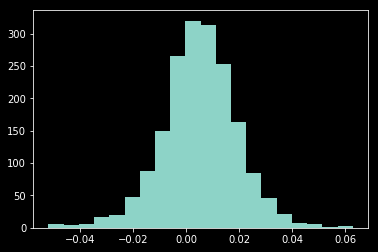

In [28]:
plt.style.use("dark_background")
plt.hist(df['abs_scores'],bins=20)

In [ ]:
#plt.hist(df['perc_tagged'],bins=20)

In [29]:
df.groupby('disease',group_keys=False)['abs_scores'].mean().sort_values()

disease
alzheimers    0.005063
Name: abs_scores, dtype: float64

#### Plotting Sentiment over time for disease

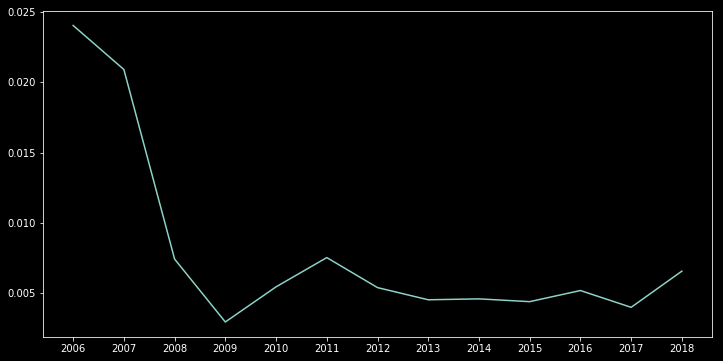

In [33]:
disease = 'alzheimers'

plot_df = df[df['disease']== disease][['abs_scores','Clean_Date']]

#aids_df.set_index('Clean_Date',inplace=True,drop=True)
#aids_df['Clean_Date'], aids_df['Clean_Date'] = aids_df['Clean_Date'].dt.year, \
#aids_df['Clean_Date'].dt.month

plot_df['group_date'] = plot_df['Clean_Date'].apply(str).apply(lambda x: x.split('-')[0]) \
                            #+ "-"+ plot_df['Clean_Date'].apply(str).apply(lambda x: x.split('-')[1]) 

yearly = pd.DataFrame(plot_df.groupby('group_date',group_keys=False)['abs_scores'].mean())
                            
#aids_df.head()

plt.figure(figsize=(12,6))
plt.plot(yearly)

#### Melting the cleaned abstract to tokens

In [ ]:
abst_tokens = pd.DataFrame(df['Clean_Abstract'].str.split(' ',expand=True),index=df.index)
#abst_tokens['Title'] = df['Article_title']

abst_tokens['article_id'] = abst_tokens.index

abst_df = pd.melt(abst_tokens, id_vars=['article_id'])

abst_df = abst_df.sort_values(by=['article_id','variable'])

abst_df.dropna(subset=['value'],inplace=True)

print(abst_df.head())

#### Creating the document-term matrix

In [ ]:
vec = CountVectorizer(decode_error='ignore')
X = vec.fit_transform(df['Clean_Abstract'])
abst = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
print(abst.head())


#### Getting most common words in dataset

In [ ]:
s = abst.sum(axis=0)#.sort(ascending=False, inplace=False)

In [ ]:
s.sort_values(ascending=False).head(100)

In [ ]:
plt.hist(s.values,bins=np.arange(min(s.values), max(s.values) + 10,10))
plt.xlim(0,250)